# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [429]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [430]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Análise e visualização de ativos

### Carrega Dados

In [431]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2000-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(4061, 4)

<Axes: ylabel='Date'>

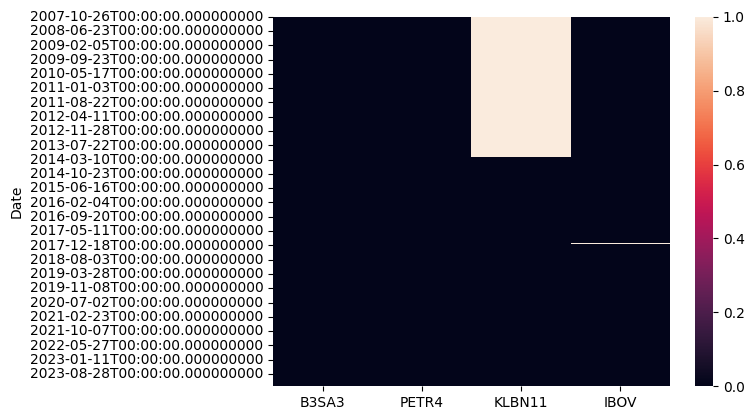

In [432]:
sns.heatmap(acoes_df.isnull())

In [433]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2024-03-11,12.580000,35.650002,22.110001,126124.0
2024-03-12,12.820000,36.820000,22.379999,127668.0
2024-03-13,12.760000,36.380001,22.680000,128006.0


### Visualização dos dados 

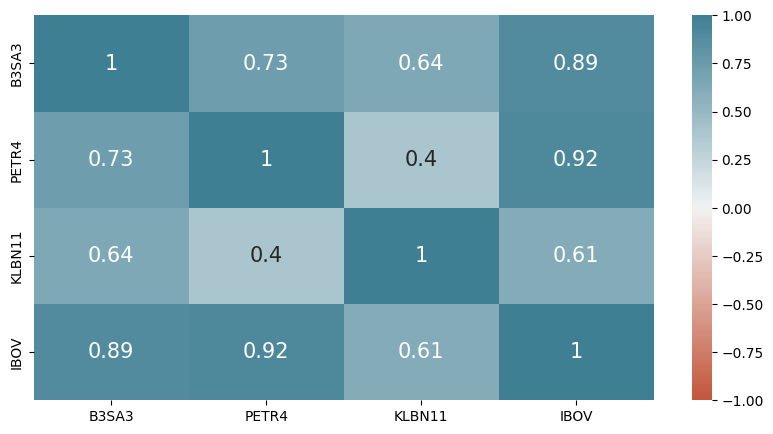

In [434]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [435]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [436]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2024-03-11,3.870769,2.304460,1.882663,2.610128
2024-03-12,3.944615,2.380090,1.905654,2.642081
2024-03-13,3.926154,2.351648,1.931199,2.649076


In [437]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [438]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [439]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [440]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [441]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')



[*********************100%%**********************]  1 of 1 completed


In [442]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [443]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [444]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [445]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


,Date,Open,High,Low,Close,Adj Close,Volume,upper_band_bollinger,lower_band_bollinger,EMA9,...,MA350*2,RSI_14,MACD,Signal,Variation,Classification,weekday,day,month,quarter
0,2015-01-02,3.270000,3.270000,3.150000,3.170000,2.279343,21734100,0.000000,0.000000,3.170000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,5,2,1,1
1,2015-01-05,3.143333,3.153333,3.056666,3.083333,2.217027,34790100,0.000000,0.000000,3.121852,...,0.000000,0.000000,-0.006914,-0.001383,-2.810824,-1,1,5,1,1
2,2015-01-06,3.066666,3.113333,3.033333,3.113333,2.238598,49214700,0.000000,0.000000,3.118360,...,0.000000,0.000000,-0.009858,-0.003078,0.963597,1,2,6,1,1
3,2015-01-07,3.133333,3.283333,3.126666,3.236666,2.327279,24006600,0.000000,0.000000,3.158437,...,0.000000,0.000000,-0.002215,-0.002905,3.810494,1,3,7,1,1
4,2015-01-08,3.296666,3.300000,3.190000,3.193333,2.296121,22967700,0.000000,0.000000,3.168818,...,0.000000,0.000000,0.000343,-0.002256,-1.356985,-1,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,2024-03-11,12.360000,12.720000,12.360000,12.580000,12.580000,34745900,13.132976,12.089024,12.465254,...,25.862286,41.964296,-0.235576,-0.258774,0.953894,1,1,11,3,1
2284,2024-03-12,12.740000,12.900000,12.640000,12.820000,12.820000,44590800,13.033289,12.146711,12.536203,...,25.856114,50.212750,-0.193012,-0.245621,1.872073,1,2,12,3,1
2285,2024-03-13,12.740000,12.960000,12.730000,12.760000,12.760000,32177000,13.017593,12.152407,12.580963,...,25.849657,52.444458,-0.162250,-0.228947,-0.470215,-1,3,13,3,1
2286,2024-03-14,12.710000,12.760000,12.410000,12.510000,12.510000,39623100,13.006881,12.145118,12.566770,...,25.840286,51.304357,-0.156243,-0.214406,-1.998401,-1,4,14,3,1


## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [446]:
ticker

'B3SA3.SA'

In [447]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [448]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [449]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

In [450]:
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [451]:
from tqdm import tqdm
import time
from keras.utils import Sequence
from keras import backend as K

class FeaturesDataGenerator(Sequence):

    def __init__(self, X_data = np.zeros([10]), lookbak=1, pred_days=1, axis=0, batch_size=32, shuffle=False, processing=None, selected_features= None):
        """
        Args:
            Features dataset_generator: The dataset generator providing input and output data.
            axis (int): Axis for feature computation.
            processing: Optional data processing function.
            selected_features (list): List of features to compute. If None, compute all features.
        """
        self.InputData = X_data
        self.lookbak = lookbak
        self.pred_days= pred_days
        self.inputShape = X_data.shape
        #self.outputShape = dataset_generator.__getitem__(0)[1].shape
        self.processing = processing
        self.axis = axis
        self.selected_features = selected_features

        self.features = self.comput_features(self.InputData)
        self.inputShape  = self.features.shape
        self.y_classification = self.comput_outputs(self.InputData)[self.pred_days:]
        self.output_shape=self.y_classification[0].shape

        self.batchSize= batch_size
        self.shuffle = shuffle

        #self.indices=np.arange(self.__len__() + self.batchSize)
        self.indices=np.arange(self.__len__() )
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __len__(self):

        return (np.max(self.inputShape) // self.batchSize) 
    #- (len(self.selected_features)+self.lookbak)
    
    def autorregressive_coefs(self,emg_data,p=3):
        channels=emg_data.shape(self.axis) 

        phi=np.zeros([emg_data.shape[0],emg_data.shape[1],p])

        ar_coefs=np.zeros([channels,p])

        y_init=[]

        y = y_train

        aux=np.zeros(p)
        for k in range(p): 
            aux[p-k:]=y[:k]
            y_init.append(aux.copy())

        phi=np.vstack([y[i-p:i] if i-p>=0 else y_init[i]  for i in range(0, len(y))])

        ar_coefs[:]=np.linalg.inv(phi[:].T.dot(phi[:])).dot(phi[:].T.dot(emg_data[:]))
            
        return ar_coefs
    
    def moving_average(self,data, window_length):
        """
        Calculates the Moving Average (MA) of a time series data.

        Args:
            data: A list or NumPy array containing the time series data.
            window_length: The number of periods to use for the MA calculation (window size).

        Returns:
            A NumPy array containing the MA values for each data point.
        """

        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")

        # Initialize empty array for MA values
        moving_average_values = np.zeros(len(data))

        # Iterate through the data
        for i in range(len(data)):
            # Check if the window goes beyond the data boundary
            if i < window_length - 1:
                # If within the initial window, use the average of available data points
                moving_average_values[i] = np.mean(data[:i+1])
            else:
                # For other points, use the average of the window
                window_slice = data[i - window_length + 1 : i + 1]
                moving_average_values[i] = np.mean(window_slice)

        return moving_average_values
    def exponential_moving_average(self, data, window_length):
        """
        Calculates the Exponential Moving Average (EMA) of a time series data.

        Args:
            data: A list or NumPy array containing the time series data.
            window_length: The number of periods to use for the EMA calculation.

        Returns:
            A NumPy array containing the EMA values for each data point.
        """

        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")

        ema = np.zeros(len(data))
        # Handle the initial EMA calculation (use simple average for the first window_length elements)
        ema[:window_length] = np.mean(data[:window_length])
        alpha = 2 / (1 + window_length)  # Smoothing factor (weight for the current data point)

        for i in range(window_length, len(data)):
            ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]

        return ema
    
    def macd(self,data, fast_period=12, slow_period=26, signal_period=9):
        """
        Calculates the MACD (Moving Average Convergence Divergence) indicator for a time series data.

        Args:
            data: A list or NumPy array containing the closing price data.
            fast_period: The number of periods for the fast Exponential Moving Average (EMA). (default: 12)
            slow_period: The number of periods for the slow Exponential Moving Average (EMA). (default: 26)
            signal_period: The number of periods for the EMA of the MACD difference. (default: 9)

        Returns:
            A tuple containing three NumPy arrays:
                - macd: The MACD line (fast EMA minus slow EMA)
                - macd_signal: The signal line (EMA of the MACD difference)
                - macd_histogram: The MACD histogram (MACD minus signal line)
        """

        # Check if window lengths are positive integers
        if any(period < 1 for period in [fast_period, slow_period, signal_period]):
            raise ValueError("Window lengths must be positive integers.")

        # Calculate the fast EMA and slow EMA
        ema_fast = self.exponential_moving_average(data, fast_period)
        ema_slow = self.exponential_moving_average(data, slow_period)

        # Calculate the MACD line (fast EMA minus slow EMA)
        macd = ema_fast - ema_slow

        # Calculate the MACD signal line (EMA of the MACD difference)
        macd_signal = self.exponential_moving_average(macd, signal_period)

        # Calculate the MACD histogram (MACD minus signal line)
        macd_histogram = macd - macd_signal

        return macd, macd_signal, macd_histogram
    
    def rsi(self,data, period=14):
        """
        Calculates the Relative Strength Index (RSI) indicator for a time series data.

        Args:
            data: A list or NumPy array containing the closing price data.
            period: The number of periods to consider for calculating gains and losses. (default: 14)

        Returns:
            A NumPy array containing the RSI values for each data point.
        """

        if period < 1:
            raise ValueError("Period must be a positive integer.")

        # Calculate the difference between closing prices
        delta = np.diff(data)

        # Separate positive and negative changes
        up_changes = delta[delta > 0]
        down_changes = np.abs(delta[delta < 0])  # Make negative changes positive

        # Calculate the Average Gain (smoothed using EMA)
        if len(up_changes) > 0:
            avg_gain = self.exponential_moving_average(up_changes, period)
        else:
            avg_gain = np.zeros_like(down_changes)  # Handle case with no positive changes

        # Calculate the Average Loss (smoothed using EMA)
        if len(down_changes) > 0:
            avg_loss = self.exponential_moving_average(down_changes, period)
        else:
            avg_loss = np.zeros_like(up_changes)  # Handle case with no negative changes

        # Calculate the Relative Strength (RS)
        rs = np.divide(avg_gain, avg_loss, where=avg_loss != 0)  # Avoid division by zero

        # Calculate the RSI
        rsi_values = 100 - (100 / (1 + rs))

        return rsi_values
    

    def windowing(self, data, lookback= 1):
        y_window = []
        for current_k in np.arange(lookback,len(data),1):
            y_window += [data[current_k-lookback:current_k]]
        y_window = np.array(y_window)
        return y_window
    
    def comput_features(self, x_data):
        """
        Args:
            emg_data (numpy.ndarray): Input EMG data.

        Returns:
            numpy.ndarray: Feature matrix computed from the input data.
        """
        
        # list with the all features. Bag of features 
        all_features = {
            'Data_lookback': self.windowing(x_data,lookback = self.lookbak),
            'EMA9': self.exponential_moving_average(x_data, window_length=9)[self.lookbak:], 
            'EMA20': self.exponential_moving_average(x_data, window_length=20)[self.lookbak:], 
            'EMA50': self.exponential_moving_average(x_data, window_length=50)[self.lookbak:], 
            'EMA100': self.exponential_moving_average(x_data, window_length=100)[self.lookbak:],  
            'EMA200': self.exponential_moving_average(x_data, window_length=200)[self.lookbak:], 
            'MA111': self.moving_average(x_data, window_length=111)[self.lookbak:],  
            'MA350': self.moving_average(x_data, window_length=350)[self.lookbak:],
            'MACD': self.macd(x_data)[0][self.lookbak:],  
            'RSI_14': self.exponential_moving_average(x_data, window_length=200)[self.lookbak:],
            }   
                           
        if self.selected_features is None:
            selected_features = [key for key in all_features.keys()]
            
        else:
            selected_features = self.selected_features

        if 'Data_lookback' in selected_features:
            _selected_features = selected_features.copy()
            _selected_features.remove('Data_lookback')
            Data_lookback = np.vstack(all_features['Data_lookback'])
            if len(_selected_features) == 0:
                features = Data_lookback
            else:
                features = np.hstack([all_features[feature][:, np.newaxis] for feature in _selected_features])
                features = np.concatenate([Data_lookback,features],axis=1)
        else:
            features = np.hstack([all_features[feature][:, np.newaxis] for feature in selected_features])

        self.features_name = selected_features

        if self.processing is not None:
            features, _ = self.processing(features, features)

        return features
    
    def comput_outputs(self, close_prices, days_lookback=1, positive_threshold=3, negative_threshold=-1):
        """
        Computes variation, classifies it into buy, sell, or hold categories, and creates y_classification array.

        Args:
            close_prices (np.ndarray): NumPy array containing the closing prices.
            positive_threshold (float): Threshold for buy classification.
            negative_threshold (float): Threshold for sell classification.

        Returns:
            np.ndarray: y_classification array containing buy, sell, or hold flags.
        """
        close_prices=close_prices[self.pred_days:]
        # Calculate percentage variations
        variations = ((close_prices - np.roll(close_prices, days_lookback)) / close_prices) * 100

        # Classify variations (vectorized)
        buy_flags = np.where(variations > positive_threshold, 1, 0)
        sell_flags = np.where(variations < negative_threshold, 1, 0)
        hold_flags = np.where((variations <= positive_threshold) & (variations >= negative_threshold), 1, 0)

        # Combine flags into y_classification (ensure correct column order)
        y_classification = np.vstack([hold_flags, buy_flags, sell_flags]).T

        return y_classification

    def __getFeaturesName__(self):
        return self.features_name


    def __getitem__(self, idx):

        batch_indices = self.indices[idx : idx + self.batchSize]
        window=len(self.selected_features)+self.lookbak-1
        if self.batchSize >1:
            features = np.zeros([self.batchSize, window])
            y = np.zeros([self.batchSize,self.output_shape[0]])
            
            for i, j in enumerate(batch_indices):
                features[i,:] = self.features[j]
                y[i,:] = self.y_classification[j]
        else:
            features = self.features[self.indices[idx]]
            features = features.reshape(1,-1)
            y = self.y_classification[self.indices[idx]]
            y=y.reshape(1,-1)

        # Convertendo features e y para tensores do TensorFlow
        features = tf.convert_to_tensor(features, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)

        return features, y

    def on_epoch_end(self):
        """Override the superclass method to shuffle the data on the end of the epoch
        """
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
    def getitem(self, index):
        """Public method to retrieve the batches during the training

        Args:
            index (int): batch indexs
        Returns:
            tuple[ndarray, ndarray]: (x[samples, ch], y[class]) data
        """
        return self.__getitem__(index)
    
    def split_data(self,X : np.array , date_time : np.datetime64,factor=0.70):
        """Split the data in train validation or test

        Args:
            X (np.array): _description_
            y (np.array): _description_
            date_time (np.datetime64): _description_
            factor (float, optional): _description_. Defaults to 0.70.

        Returns:
            _type_: _description_
        """
        nits=round(len(X)*factor)

        X_train=X[:nits]

        nit_test= np.max(X_train.shape) -1
        X_test = X[nit_test:]

        T_train = date_time[:nits]
        T_test = date_time[nit_test:]
        
        return X_train,X_test, T_train, T_test
    
    def weighted_categorical_crossentropy(self,weights):
        """
        from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
        A weighted version of keras.objectives.categorical_crossentropy
        
        Variables:
            weights: numpy array of shape (C,) where C is the number of classes
        
        Usage:
            weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
            loss = weighted_categorical_crossentropy(weights)
            model.compile(loss=loss,optimizer='adam')
        """
        
        weights = K.variable(weights)
            
        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            # calc
            loss = y_true * K.log(y_pred) * weights
            loss = -K.sum(loss, -1)
            return loss
        
        return loss

In [452]:
# separa os dados em Treino e Teste
split_data=FeaturesDataGenerator().split_data
X_train, X_test, T_train, T_test=split_data(df_norm['Close'].values, df_norm['Date'], factor=0.90)
X_train, X_val, T_train, T_val=split_data(X_train.T, T_train, factor=0.70)
X_train.shape

/tmp/ipykernel_710750/3734845546.py:268: RuntimeWarning:

invalid value encountered in divide



(1441,)

In [453]:
features_indicators=FeaturesDataGenerator().features_name
#features_indicators=['Data_lookback','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200']
#features_indicators=['Data_lookback']
pred_days = 1
lookback = 23
batch_size = 4
shuffle = False
X_data_gen_train = FeaturesDataGenerator(X_train, lookbak = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators)
X_data_gen_val = FeaturesDataGenerator(X_val, lookbak = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators)
X_data_gen_test = FeaturesDataGenerator(X_test, lookbak = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators)

/tmp/ipykernel_710750/3734845546.py:268: RuntimeWarning:

invalid value encountered in divide



In [454]:
X_data_gen_train.comput_features(X_train)

array([[ 0.01177876,  0.00734036,  0.00887672, ...,  0.01111725,
         0.00156885,  0.03634003],
       [ 0.00734036,  0.00887672,  0.01519286, ...,  0.01125979,
         0.00185879,  0.03634003],
       [ 0.00887672,  0.01519286,  0.01297368, ...,  0.01122722,
         0.00144757,  0.03634003],
       ...,
       [ 0.84397415,  0.80539439,  0.80573578, ...,  0.65395801,
        -0.01916618,  0.73093203],
       [ 0.80539439,  0.80573578,  0.85199732, ...,  0.65503395,
        -0.01581527,  0.73173749],
       [ 0.80573578,  0.85199732,  0.82724483, ...,  0.65608892,
        -0.01405823,  0.73240415]])

In [455]:
X_data_gen_train.comput_outputs(X_train).shape

(1440, 3)

In [456]:
variations = ((X_train - np.roll(X_train, 1)) / X_train) * 100
recomendations=pd.DataFrame(data=np.hstack([np.vstack([variations[1:],X_train[1:]]).T,X_data_gen_train.comput_outputs(X_train)]), columns=['var','X', 'Hold','Buy','Sell'])
recomendations.tail(30)

,var,X,Hold,Buy,Sell
1410,-0.156403,0.873165,1.0,0.0,0.0
1411,-4.387758,0.836463,0.0,0.0,1.0
1412,1.030095,0.845169,1.0,0.0,0.0
1413,-2.675241,0.823148,0.0,0.0,1.0
1414,2.467644,0.843974,1.0,0.0,0.0
1415,-4.790170,0.805394,0.0,0.0,1.0
1416,0.042370,0.805736,1.0,0.0,0.0
1417,5.429776,0.851997,0.0,1.0,0.0
1418,-2.992160,0.827245,0.0,0.0,1.0
1419,-0.539416,0.822806,1.0,0.0,0.0


In [457]:
from sklearn.utils import class_weight
output_class_weights = class_weight.compute_class_weight('balanced', classes=np.arange(3), y=np.argmax(X_data_gen_train.comput_outputs(X_train),axis=1))
print(output_class_weights)
weighted_categorical_crossentropy_loss= X_data_gen_train.weighted_categorical_crossentropy(output_class_weights)

[0.81355932 1.53354633 0.89385475]


## Neural Networkt aproach

In [458]:

X_data,y_data=X_data_gen_train[0]
n_classes=y_data.shape[1]


In [459]:
X_data.shape

TensorShape([4, 32])

### Used Models

#### CNN_LSTM

In [460]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.models import Model

# Model name
model_name = "CNN_LSTM_MultiHead"
#np.random.seed(42)

# Define CNN-LSTM feature extraction function
def CNN_LSTM(inputs):
  x = Conv1D(64, kernel_size=1, strides=1, activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.2)(x)
  return x

def CNN_bracnh(Features):
    x = Conv1D(164, kernel_size=1, strides=1, activation='relu')(Features)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x
  
# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation, name= None):
  x = Dense(256)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(n_outputs)(x)

  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output

# Create the full model
input_shape = (X_data.shape[1], 1)  # Assuming your input shape
input_data = Input(shape=input_shape)

Features = CNN_LSTM(input_data)
features_branch1=CNN_bracnh(Features)
features_branch2=CNN_bracnh(Features)
# Create separate heads with appropriate number of outputs and activations
regression_output = head(features_branch1, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(features_branch2, n_outputs=n_classes, activation='sigmoid',name='classification_head')

# Create the model with two heads
model_CNN_LSTM = Model(inputs=input_data, outputs=[classification_output])
model_CNN_LSTM._name = model_name

# Print model summary
model_CNN_LSTM.summary()

Model: "CNN_LSTM_MultiHead"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 conv1d_56 (Conv1D)          (None, 32, 64)            128       
                                                                 
 batch_normalization_160 (B  (None, 32, 64)            256       
 atchNormalization)                                              
                                                                 
 max_pooling1d_56 (MaxPooli  (None, 16, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_104 (Dropout)       (None, 16, 64)            0         
                                                                 
 conv1d_58 (Conv1D)          (None, 16, 164)    

In [461]:
X_data.shape

TensorShape([4, 32])

In [462]:
# Model name
model_name = "CNN_MultiHead"
#np.random.seed(42)

def common_layers(input1):
        """Common layers to the network model

        Returns:
            Graph: the common layers model
        """

        ##################################################################
        # CNN architecture
        conv_layer = Conv1D(64, (3), padding="same")(input1)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=1, padding="same")(conv_layer)
        conv_layer = Conv1D(128, (3), padding="same")(conv_layer)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=2, padding="same")(conv_layer)
        
        ##################################################################

        return conv_layer

def head_layer(conv_layer, num_classes, activation='linear', output_name=None):
    
    head1 = Conv1D(64, (3), padding="same")(conv_layer)
    head1 = BatchNormalization()(head1)
    head1 = Activation('relu')(head1)
    head1 = MaxPooling1D(pool_size=(3), strides=2, padding="same")(head1)

    head1 = Dropout(0.5)(head1)
    head1 = Flatten()(head1)

    x = Dense(256)(head1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(num_classes)(x)
    x = Activation(activation, name=output_name)(x)

    return x

# Create the full model
input_data = Input(shape=input_shape)

Features = common_layers(input_data)
# Create separate heads with appropriate number of outputs and activations
regression_output = head_layer(Features, num_classes=pred_days, activation='linear',output_name='regression_head')
classification_output = head_layer(Features, num_classes=n_classes, activation='softmax',output_name='classification_head')

# Create the model with two heads
model_CNN_MultiHead = Model(inputs=input_data, outputs=[classification_output])
model_CNN_MultiHead._name = model_name

# Print model summary
model_CNN_MultiHead.summary()

Model: "CNN_MultiHead"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 conv1d_59 (Conv1D)          (None, 32, 64)            256       
                                                                 
 batch_normalization_165 (B  (None, 32, 64)            256       
 atchNormalization)                                              
                                                                 
 activation_138 (Activation  (None, 32, 64)            0         
 )                                                               
                                                                 
 max_pooling1d_59 (MaxPooli  (None, 32, 64)            0         
 ng1D)                                                           
                                                     

#### MultiLayer Perceptron

In [463]:
# Model name
model_name = "MLP"

# Input layer
input_shape = (X_data.shape[1],)  # Assuming your input shape
input_data = Input(shape=input_shape)

# Dense layer 1 with batch normalization
dense1 = Dense(64)(input_data)
bn1 = BatchNormalization()(dense1)
activation1 = Activation('relu')(bn1)

# Dense layer 2 with batch normalization and dropout
dense2 = Dense(128)(activation1)
bn2 = BatchNormalization()(dense2)
activation2 = Activation('relu')(bn2)
dropout2 = Dropout(0.2)(activation2)


# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation='linear', name= None):
  """
  Defines a dense layer head for either regression or classification.

  Args:
      features: Input tensor from the feature extraction part.
      n_outputs: Number of outputs for the head.
      activation: Activation function for the output layer (defaults to 'linear' for regression).

  Returns:
      A Keras functional API model representing the head with its output.
  """

  x = Dense(64)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(n_outputs)(x)

  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output


# Create separate heads with appropriate number of outputs and activations
regression_output = head(activation2, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(activation2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model
model_MLP = Model(inputs=input_data, outputs=[classification_output])
model_MLP._name = model_name

# Print model summary
model_MLP.summary()


Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_178 (Dense)           (None, 64)                2112      
                                                                 
 batch_normalization_173 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 activation_146 (Activation  (None, 64)                0         
 )                                                               
                                                                 
 dense_179 (Dense)           (None, 128)               8320      
                                                                 
 batch_normalization_174 (B  (None, 128)               512     

#### Long Short-Term Memory (LSTM) 

In [464]:
model_name= "LSTM"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 64)                16896     
                                                                 
 batch_normalization_177 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 activation_150 (Activation  (None, 64)                0         
 )                                                               
                                                                 
 dropout_114 (Dropout)       (None, 64)                0         
                                                                 
 dense_184 (Dense)           (None, 1)                 65     

#### Long Short-Term Memory (GRU) 

In [465]:
model_name= "GRU"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)
# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 gru_8 (GRU)                 (None, 64)                12864     
                                                                 
 batch_normalization_178 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 activation_151 (Activation  (None, 64)                0         
 )                                                               
                                                                 
 dropout_115 (Dropout)       (None, 64)                0         
                                                                 
 dense_185 (Dense)           (None, 1)                 65      

#### LSTM with Attention layer

In [466]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [467]:
model_name= "LSTM_AT"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention(64)(X)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 lstm_17 (LSTM)              (None, 32, 64)            16896     
                                                                 
 batch_normalization_179 (B  (None, 32, 64)            256       
 atchNormalization)                                              
                                                                 
 activation_152 (Activation  (None, 32, 64)            0         
 )                                                               
                                                                 
 dropout_116 (Dropout)       (None, 32, 64)            0         
                                                                 
 attention_8 (Attention)     (None, 64)                4225

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [468]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [469]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    #optimizer1 = tf.keras.optimizers.RMSprop(learning_rate=0.05)
    return optimizer1
    #

**Train options callbacks**  

In [470]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

In [471]:
categorical_accuracy =tf.keras.metrics.categorical_accuracy
#loss =tf.keras.losses.categorical_crossentropy
loss =weighted_categorical_crossentropy_loss

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200



Epoch 1: val_loss improved from inf to 11.95640, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


354/354 - 2s - loss: 0.8463 - categorical_accuracy: 0.6688 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 2s/epoch - 7ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 11.95640
354/354 - 0s - loss: 0.7160 - categorical_accuracy: 0.7126 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 488ms/epoch - 1ms/step
Epoch 3/200

Epoch 3: val_loss improved from 11.95640 to 9.73123, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


354/354 - 2s - loss: 0.6967 - categorical_accuracy: 0.7352 - val_loss: 9.7312 - val_categorical_accuracy: 0.3473 - lr: 0.0500 - 2s/epoch - 5ms/step
Epoch 4/200

Epoch 4: val_loss improved from 9.73123 to 7.32157, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


354/354 - 1s - loss: 0.6406 - categorical_accuracy: 0.7415 - val_loss: 7.3216 - val_categorical_accuracy: 0.3742 - lr: 0.0500 - 1s/epoch - 3ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 7.32157
354/354 - 1s - loss: 0.6138 - categorical_accuracy: 0.7493 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 514ms/epoch - 1ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 7.32157
354/354 - 1s - loss: 0.5975 - categorical_accuracy: 0.7451 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 504ms/epoch - 1ms/step
Epoch 7/200

Epoch 7: val_loss improved from 7.32157 to 7.29539, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


354/354 - 1s - loss: 0.6026 - categorical_accuracy: 0.7472 - val_loss: 7.2954 - val_categorical_accuracy: 0.3540 - lr: 0.0500 - 1s/epoch - 4ms/step
Epoch 8/200

Epoch 8: val_loss did not improve from 7.29539
354/354 - 1s - loss: 0.5676 - categorical_accuracy: 0.7571 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 589ms/epoch - 2ms/step
Epoch 9/200

Epoch 9: val_loss did not improve from 7.29539
354/354 - 1s - loss: 0.5730 - categorical_accuracy: 0.7444 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 564ms/epoch - 2ms/step
Epoch 10/200

Epoch 10: val_loss did not improve from 7.29539
354/354 - 1s - loss: 0.5493 - categorical_accuracy: 0.7535 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 555ms/epoch - 2ms/step
Epoch 11/200

Epoch 11: val_loss did not improve from 7.29539
354/354 - 1s - loss: 0.5561 - categorical_accuracy: 0.7528 - val_loss: 11.9564 - val_categorical_accuracy: 0.1124 - lr: 0.0500 - 509ms/epoch - 1ms/step


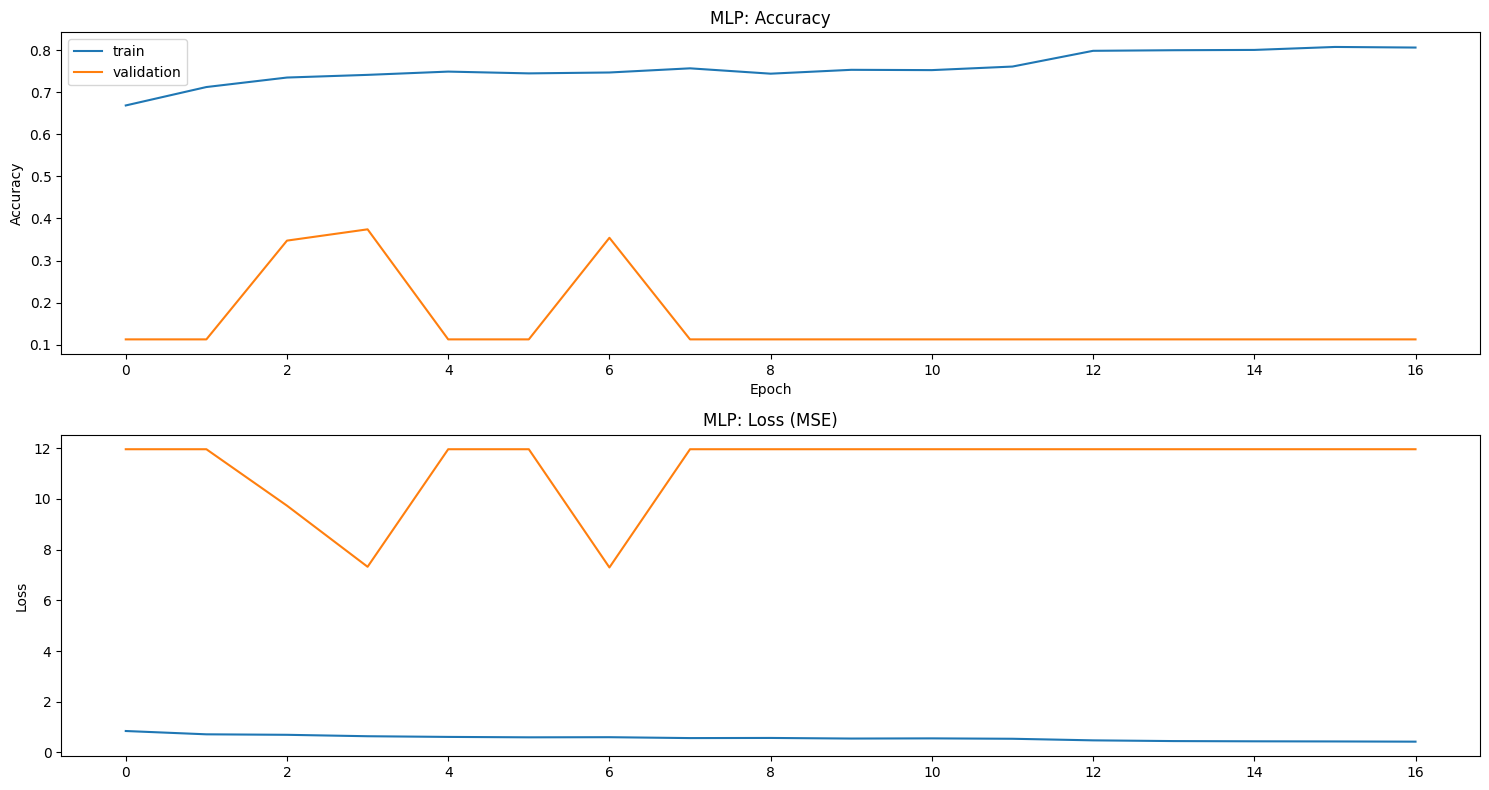

Training model : models/model_GRU_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.00000, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


354/354 - 5s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 5s/epoch - 15ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.00000
354/354 - 2s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 2s/epoch - 7ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.00000
354/354 - 2s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 2s/epoch - 6ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.00000
354/354 - 2s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 2s/epoch - 6ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.00000
354/354 - 2s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 -

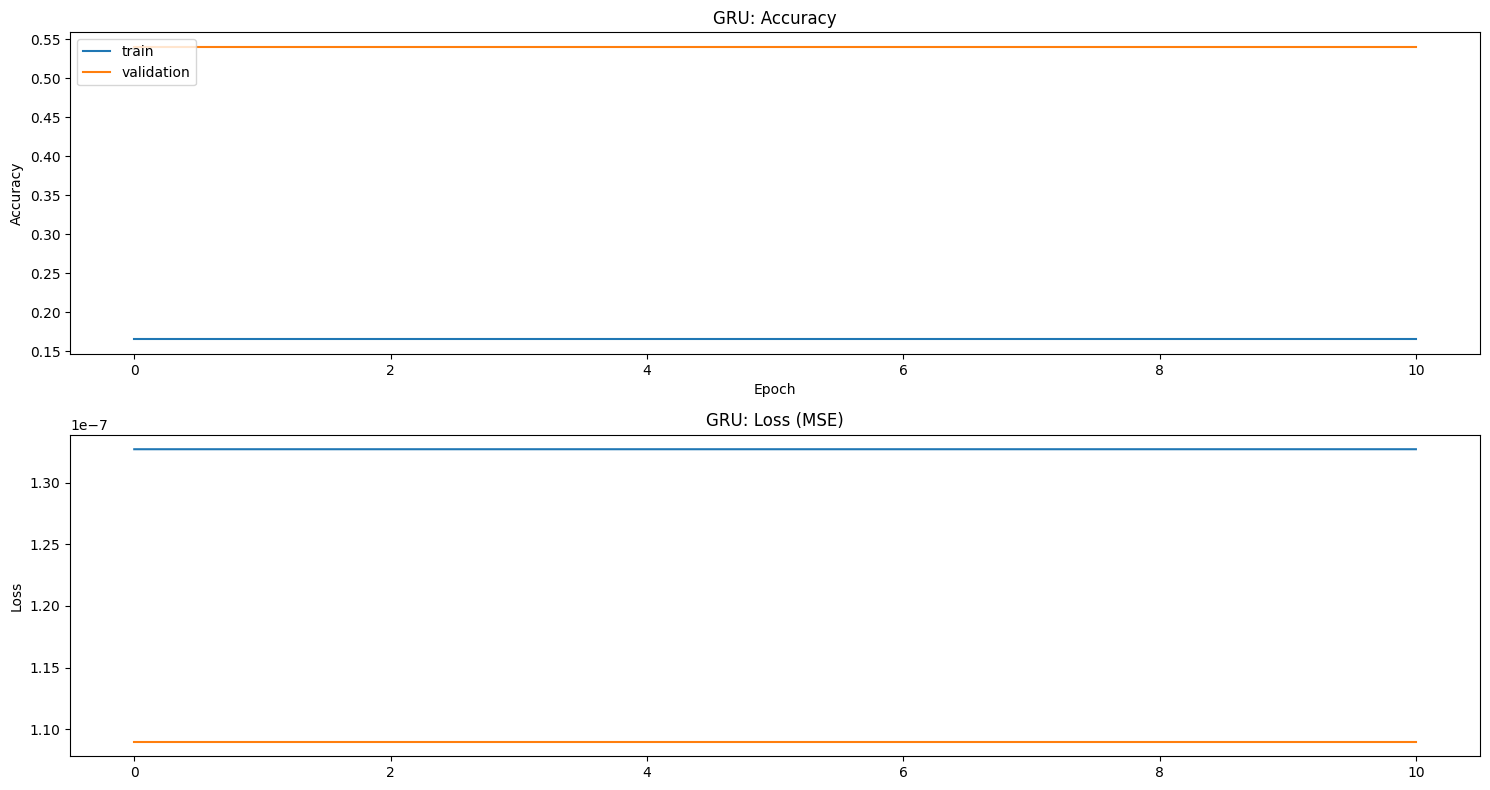

Training model : models/model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM_MultiHead
Epoch 1/200

Epoch 1: val_loss improved from inf to 1.00435, saving model to models/model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_MultiHead_stock_B3SA3_lookback_23/assets


354/354 - 4s - loss: 1.2474 - categorical_accuracy: 0.2860 - val_loss: 1.0043 - val_categorical_accuracy: 0.5302 - lr: 0.0500 - 4s/epoch - 11ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 1.00435
354/354 - 1s - loss: 1.2232 - categorical_accuracy: 0.2133 - val_loss: 1.0043 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 1s/epoch - 4ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 1.00435
354/354 - 1s - loss: 1.2232 - categorical_accuracy: 0.2267 - val_loss: 1.0043 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 1s/epoch - 4ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 1.00435
354/354 - 2s - loss: 1.2258 - categorical_accuracy: 0.1907 - val_loss: 1.0043 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 2s/epoch - 5ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 1.00435
354/354 - 2s - loss: 1.2232 - categorical_accuracy: 0.1660 - val_loss: 1.0043 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 2s/epoch - 5ms/step
Epoch 6/200

Epoch 

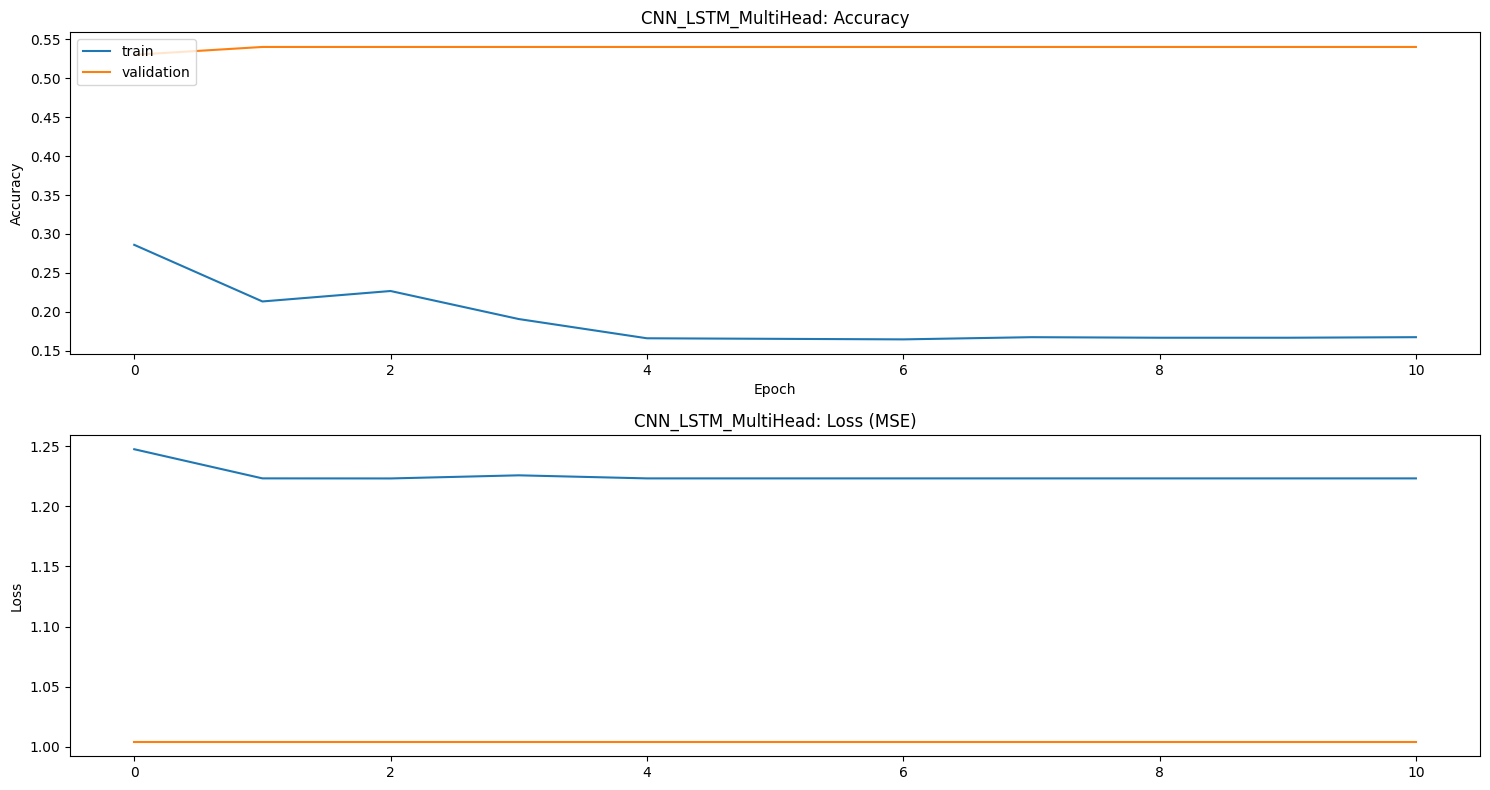

Training model : models/model_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.00000, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


354/354 - 6s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 6s/epoch - 18ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.00000
354/354 - 2s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 2s/epoch - 6ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.00000
354/354 - 2s - loss: 1.3273e-07 - categorical_accuracy: 0.1653 - val_loss: 1.0898e-07 - val_categorical_accuracy: 0.5403 - lr: 0.0500 - 2s/epoch - 7ms/step
Epoch 4/200


In [472]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]
#list_of_models=[model_MLP,model_CNN_MultiHead]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss=[loss], optimizer=optimizer, metrics=['categorical_accuracy'])
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    #history=model.fit( X_data_gen_train, validation_data=X_data_gen_val, epochs=200, batch_size=32, shuffle=False, validation_split=0.3, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])
    #history=model.fit_generator( X_data_gen_train, epochs=200, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger], validation_data=X_data_gen_val, verbose=0)
    history = model.fit(
        X_data_gen_train,
        epochs=200,
        callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback, csvLogger],
        validation_data=X_data_gen_val,
        #shuffle=False,
        verbose=2
    )
    # Assuming history_metric, history_metric_val, history are defined elsewhere

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))  # Create subplots programmatically

    # Plot accuracy, sharing x-axis with NRMSE
    axes[0].plot(history.history['categorical_accuracy'])
    axes[0].plot(history.history['val_categorical_accuracy'])
    axes[0].set_title(f'{model._name}: Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')  # Shared x-axis label
    axes[0].legend(['train', 'validation'], loc='upper left')

    # Plot loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title(f'{model._name}: Loss (MSE)')
    axes[1].set_ylabel('Loss')

    # Adjust spacing and margins (optional)
    plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.2)

    # Fine-tune spacing (optional)
    plt.tight_layout()

    plt.show()

    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

In [ ]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'loss': weighted_categorical_crossentropy_loss})

In [ ]:
X_data_gen_test = FeaturesDataGenerator(X_test, lookbak = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=1, selected_features = features_indicators)

test_data=[]
targets=[]
for X,y in X_data_gen_test:
    #train_data+=[scaler.transform(np.array(X).reshape(-1,1))]
    test_data+=[np.array(X)]
    targets+=[np.argmax(y)]
targets = np.stack(targets)
test_data = np.vstack(test_data)

In [ ]:
'''data_real_gen_train = FeaturesDataGenerator(df['Close'].values, lookbak = lookback, pred_days = pred_days, shuffle= True, batch_size=1, selected_features = features_indicators)
comput_features= data_real_gen_train.comput_features
comput_outputs=data_real_gen_train.comput_outputs

train_data=[]
targets=[]
for X,y in data_real_gen_train:
    train_data+=[scaler.transform(np.array(X).reshape(-1,1))]
    targets+=[np.argmax(y)]
targets = np.stack(targets)
train_data = np.hstack(train_data)'''

"data_real_gen_train = FeaturesDataGenerator(df['Close'].values, lookbak = lookback, pred_days = pred_days, shuffle= True, batch_size=1, selected_features = features_indicators)\ncomput_features= data_real_gen_train.comput_features\ncomput_outputs=data_real_gen_train.comput_outputs\n\ntrain_data=[]\ntargets=[]\nfor X,y in data_real_gen_train:\n    train_data+=[scaler.transform(np.array(X).reshape(-1,1))]\n    targets+=[np.argmax(y)]\ntargets = np.stack(targets)\ntrain_data = np.hstack(train_data)"

In [ ]:
'''y_train, y_test, T_train, T_test=split_data( targets.T, df_norm['Date'], factor=0.85)
X_train, X_test, T_train, T_test=split_data( train_data.T, df_norm['Date'], factor=0.85)
y_train, y_test, T_train, T_test=split_data( targets.T, df_norm['Date'], factor=0.85)'''
X_train.shape

(1441,)

In [ ]:
import utils
for model_name in trained_best_models:
    label_pred = trained_best_models[model_name].predict(test_data)
    print(model_name,' classification Accuracy',utils.accuracy_score(targets, np.argmax(label_pred,axis=1)))
#utils.model_metrics(['subida','Descida'], y_test, y_pred, Get_metrics=False)

#utils.plot_confusion_matrix(['subida','Descida'], y_test, y_pred)

7/7 [==============================] - 0s 1ms/step


MLP  classification Accuracy 0.3333333333333333
7/7 [==============================] - 0s 3ms/step
CNN_MultiHead  classification Accuracy 0.10144927536231885


### Get new values to future prediction 

In [ ]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-03-15
Estamos Fornecendo dados até o dia : 2024-03-14
O modelo fará previsões até o dia:  2024-03-21


In [ ]:
new_predictions=[]
y_pred_classification=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test[0].copy()
        y_pred_head2=y_test.copy()
        # normalized data
        X_inputs=comput_features(scaler.transform(y_test_real_regression.reshape(-1,1)),lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[0][:-dias_antes].copy()
        y_pred_head2=y_test[1][:-dias_antes].copy()
    
        X_inputs=comput_features(scaler.transform(y_test_real_regression.reshape(-1,1))[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    
    for k in range(n_steps):
        # normalzação das features
        #for idx in range(len(features_indicators)+lookback):
        #    X_inputs[-1,idx]=np.squeeze(scaler.transform(X_inputs[-1,idx].reshape(-1,1)))
        

        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))
        y_pred_head2 = np.append(y_pred_head2,y_pred[1],axis=0)
        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)

        
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
    
    y_pred_classification +=[y_pred_head2]
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]

y_pred_classification=np.array(y_pred_classification)
new_predictions=np.hstack(new_predictions)

NameError: name 'y_test' is not defined

In [ ]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train[0],y_test[0][:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real_regression, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [ ]:
trained_best_models

{'CNN_MultiHead': <keras.src.engine.functional.Functional at 0x2ab7b7033d0>}

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM_MultiHead')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df['Subida_pred'] = np.argmax(y_pred_classification[model_idx],axis=1)
pred_data_df.tail(10)

ValueError: 'CNN_LSTM_MultiHead' is not in list

In [ ]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

,Data,pred,Variacao,Subida,Subida_pred
339,2024-03-11,13.284036,6.203206,1,1


In [ ]:
result=pred_data_df.iloc[-1:,:]
result

,Data,pred,Variacao,Subida,Subida_pred
343,2024-03-15,13.552655,0.64,1,1


In [ ]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-03-15 é de subida, de 0.64% o valor predito é de: 13.55


In [ ]:
comput_features(y_test[0], lookback, features_indicators).reshape(1,-1)

array([[ 0.52594748,  0.53721414,  0.52338687,  0.52748383,  0.50802325,
         0.4993172 ,  0.50136568,  0.4993172 ,  0.51212021,  0.50546269,
         0.49726872,  0.48702633,  0.48856268,  0.50238995,  0.4936839 ,
         0.5064869 ,  0.48548998,  0.47934455,  0.47371119,  0.47678393,
         0.48036876,  0.48753846,  0.4936839 ,  0.48780755,  0.49677713,
         0.51462067,  0.52077532,  0.52018204,  0.51203718,  0.        ,
        -0.01206435,  0.52200291,  0.46854002]])

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM_MultiHead')
model=list_of_models[model_idx]
X_features=comput_features(y_test[0], lookback, features_indicators).reshape(1,-1)
preds=model.predict(X_features)
scaler.inverse_transform(preds[0])

1/1 [==============================] - 1s 526ms/step


array([[13.245084]], dtype=float32)

In [ ]:
preds

[array([[0.5277442]], dtype=float32),
 array([[0.02031025, 0.9796897 ]], dtype=float32)]